In [35]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBRegressor
from boruta import BorutaPy
from scipy.stats import pearsonr, spearmanr, kendalltau
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
#Preprocessing
data = pd.read_csv(r'\Users\yazda\Desktop\AyeAye2024\Aye-Aye-Project\data\LEK\LEK_data_grouped.csv', delimiter=';')
data.head(10)
data.columns
data['edu.level'] = data['edu.level'].replace({np.nan: 'NoEdu'})
selected_columns_dm = data[['Clove.benefit.score', 'Region', 'Gender', 'Age',
       'edu.level', 'Ethnic.group', 'Migration.Experience', 'Farms.Cloves'
       ,'encountered.binary', 'ID.vis.Aye-aye', 'ID.nom',
       'Knowledge.non.benefit.score.max.6', 'DK.score',
       'Diet.Insects', 'Knowledge.signs', 'Remoteness', 'village.size',
       'School', 'Forest.cover2017', 'Forest.cover1990', 'Forestloss_total',
       'Forestloss_relative', 'Farms.Paddy.Rice', 'Farms.Tavy.Rice',
       'Extracts.Medical.plants', 'FES.provisioning', 'FES.regulating',
       'FES.cultural', 'FES.supporting', 'ID.vis.Indri', 'ID.vis.Microcebus',
       'Aye.aye.protected']]


In [28]:
column_dtypes = selected_columns_dm.dtypes
print(column_dtypes)


Clove.benefit.score                   int64
Region                                int64
Gender                                int64
Age                                  object
edu.level                            object
Ethnic.group                          int64
Migration.Experience                  int64
Farms.Cloves                          int64
encountered.binary                    int64
ID.vis.Aye-aye                        int64
ID.nom                                int64
Knowledge.non.benefit.score.max.6     int64
DK.score                              int64
Diet.Insects                          int64
Knowledge.signs                       int64
Remoteness                            int64
village.size                          int64
School                                int64
Forest.cover2017                     object
Forest.cover1990                     object
Forestloss_total                     object
Forestloss_relative                  object
Farms.Paddy.Rice                

In [29]:
for column in selected_columns_dm.columns:
    unique_values = selected_columns_dm[column].unique()
    print(f"Unique values in '{column}':\n{unique_values}\n")

Unique values in 'Clove.benefit.score':
[1 0]

Unique values in 'Region':
[0 1 2 3]

Unique values in 'Gender':
[1 0]

Unique values in 'Age':
['51-60' '41-50' '21-30' '14-20' '31-40' '>70' '61-70']

Unique values in 'edu.level':
['NoEdu' 'High' 'Primary' 'Secondary']

Unique values in 'Ethnic.group':
[1 3 2]

Unique values in 'Migration.Experience':
[0 1]

Unique values in 'Farms.Cloves':
[1 0]

Unique values in 'encountered.binary':
[0 1]

Unique values in 'ID.vis.Aye-aye':
[0 1]

Unique values in 'ID.nom':
[0 1]

Unique values in 'Knowledge.non.benefit.score.max.6':
[4 5 3 6 0 1 2]

Unique values in 'DK.score':
[ 2  0  1  3 10  4  7  9  5  8 14 11  6 13 12]

Unique values in 'Diet.Insects':
[1 0]

Unique values in 'Knowledge.signs':
[0 1]

Unique values in 'Remoteness':
[1 5 4 3 2]

Unique values in 'village.size':
[4 2 1 5 3]

Unique values in 'School':
[1 0]

Unique values in 'Forest.cover2017':
['0-10' '50-70' '30-50' '10-30']

Unique values in 'Forest.cover1990':
['10-30' '70-90

In [36]:
def label_encode_columns(df):
    """Label encode categorical columns."""
    label_encoders = {}
    for column in df.select_dtypes(include=['object', 'category']).columns:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column].astype(str))
        label_encoders[column] = le
    return df, label_encoders

In [37]:
def calculate_and_plot_correlations(d, target_col, top_n=10):
    # Label encode categorical columns
    d, label_encoders = label_encode_columns(d)
    
    # Data Preparation    
    X = d.drop(columns=[target_col])
    y = d[target_col]
    
    # Apply StandardScaler
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    # Calculate Pearson Correlation for each feature with the target
    correlations = {col: pearsonr(X_scaled[col], y)[0] for col in X_scaled.columns}
    
    # Convert to DataFrame and sort by absolute correlation value
    corr_df = pd.DataFrame(list(correlations.items()), columns=['Feature', 'Correlation'])
    corr_df['AbsCorrelation'] = corr_df['Correlation'].abs()
    top_features = corr_df.sort_values(by='AbsCorrelation', ascending=False).head(top_n)
    
    # Plot the top_n features
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Correlation', y='Feature', data=top_features, palette='viridis')
    plt.title(f'Top {top_n} Features by Pearson Correlation with {target_col}')
    plt.show()
    
    return top_features['Feature'].tolist()


In [50]:

def feature_selection_with_top_features(d, target_col, top_features, n_features=8):
    # Label encode categorical columns
    d, label_encoders = label_encode_columns(d)
    
    # Data Preparation    
    X = d[top_features]
    y = d[target_col]
    
    # Apply StandardScaler
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    results = {}
    
    
    # XGBoost
    xgb = XGBRegressor(n_estimators=100)
    xgb.fit(X_scaled, y)
    xgb_importance = pd.DataFrame({'Feature': X_scaled.columns, 'Importance': xgb.feature_importances_})
    xgb_importance = xgb_importance.sort_values('Importance', ascending=False)
    results['XGBoost'] = (xgb_importance['Feature'].tolist(), xgb_importance['Importance'].tolist())
    
    # Random Forest
    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(X_scaled, y)
    rf_importance = pd.DataFrame({'Feature': X_scaled.columns, 'Importance': rf.feature_importances_})
    rf_importance = rf_importance.sort_values('Importance', ascending=False)
    results['Random Forest'] = (rf_importance['Feature'].tolist(), rf_importance['Importance'].tolist())
    
    # Logistic Regression
    lr = LogisticRegression(penalty='l1', solver='liblinear')
    lr.fit(X_scaled, y)
    lr_importance = pd.DataFrame({'Feature': X_scaled.columns, 'Importance': np.abs(lr.coef_[0])})
    lr_importance = lr_importance.sort_values('Importance', ascending=False)
    results['Logistic Regression'] = (lr_importance['Feature'].tolist(), lr_importance['Importance'].tolist())
    

    # Plot the selected features for each method
    for method, (features, importances) in results.items():
        plt.figure(figsize=(10, 6))
        sns.barplot(x=importances, y=features, palette='muted')
        plt.title(f'Selected Features by {method}')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.show()

    return results


C:\Users\yazda\AppData\Local\Temp\ipykernel_17024\3852934613.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Correlation', y='Feature', data=top_features, palette='viridis')


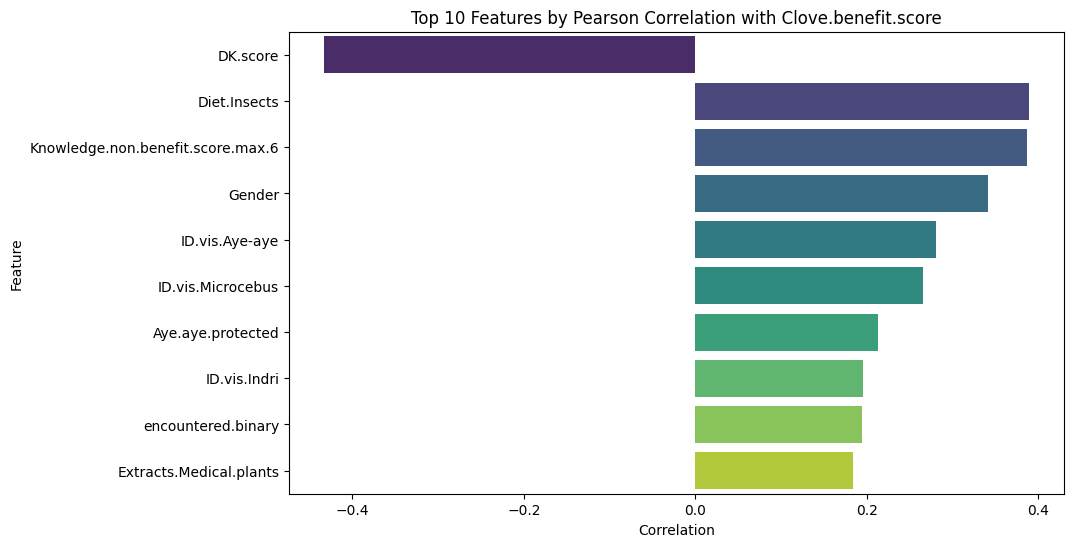

In [51]:
top_features = calculate_and_plot_correlations(selected_columns_dm, target_col='Clove.benefit.score', top_n=10)


C:\Users\yazda\AppData\Local\Temp\ipykernel_17024\2392320863.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=features, palette='muted')


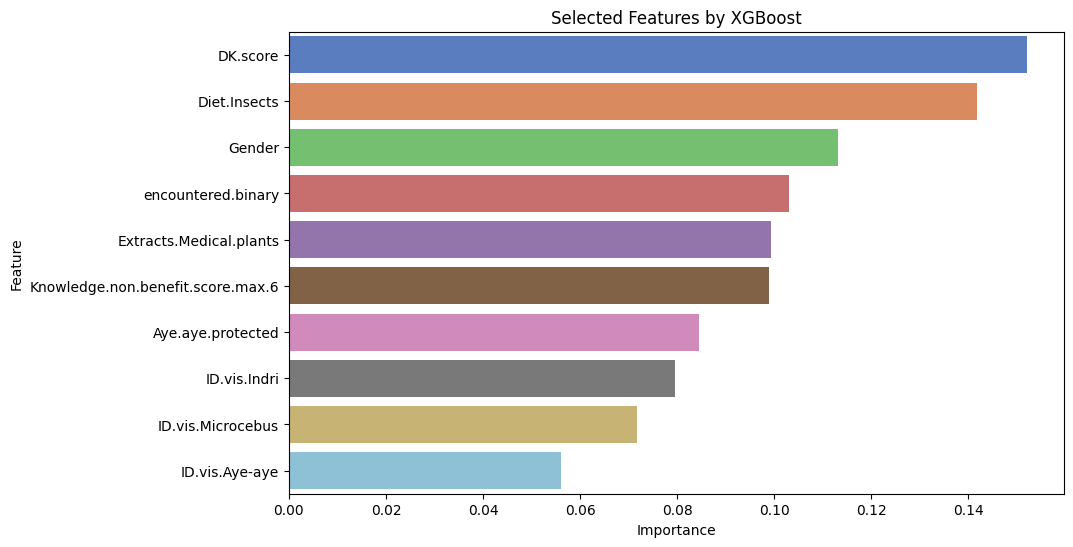

C:\Users\yazda\AppData\Local\Temp\ipykernel_17024\2392320863.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=features, palette='muted')


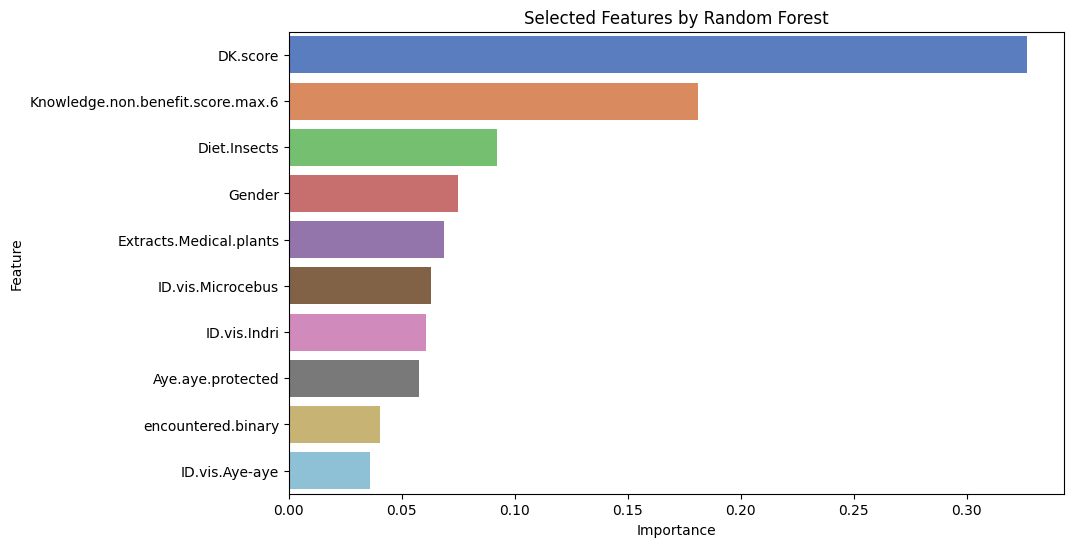

C:\Users\yazda\AppData\Local\Temp\ipykernel_17024\2392320863.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=features, palette='muted')


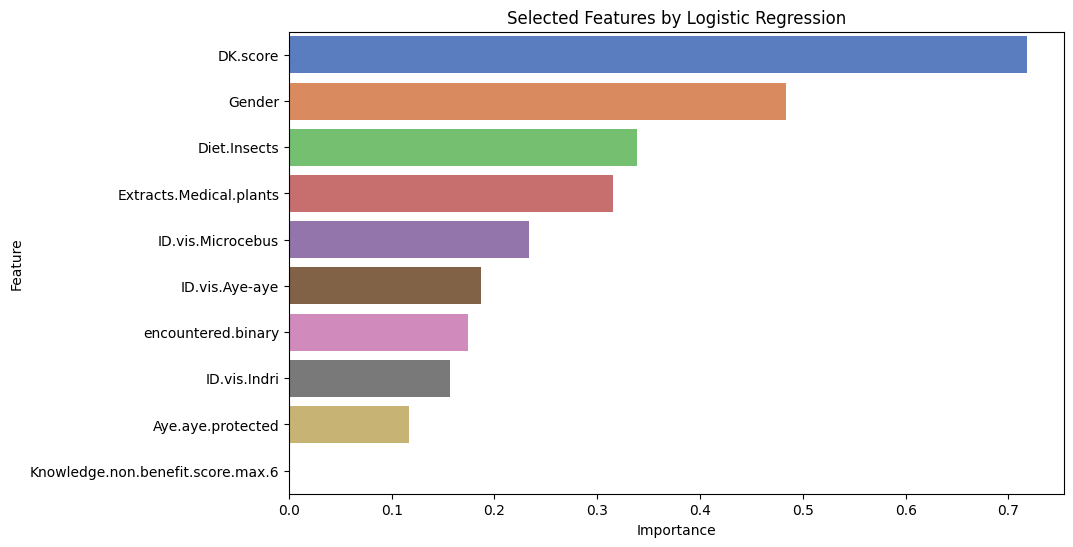

In [52]:
selected_features_results = feature_selection_with_top_features(selected_columns_dm, target_col='Clove.benefit.score', top_features=top_features)
